# Load in resources

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load and Explore the Data

Replace PayPal with IBM because PayPal does not have 5 years of data

In [43]:
import time
from datetime import datetime

start_date = '01/01/2014'
end_train_date = '12/31/2018'
end_date = '12/31/2019'

start_timestamp = int(time.mktime(datetime.strptime(start_date, '%m/%d/%Y').timetuple()))
end_timestamp = int(time.mktime(datetime.strptime(end_date, '%m/%d/%Y').timetuple()))

stock_tickers = ['AAPL', 'MSFT', 'INTC', 'CSCO', 'ADBE', 'CRM', 'NVDA', 'ACN', 'IBM', 'ORCL']

## Get the Data from Yahoo Finance

In [44]:
from requests import request
import json

def create_dataframe(response, symbol):
    df = pd.DataFrame(json.loads(response.text)['prices'])
    df = df[['date', 'adjclose']].copy()
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df = df.dropna()
    df = df.set_index('date')
    df = df.rename(columns={'adjclose': symbol})
    df.sort_index(inplace=True, ascending=True)
    return df

def load_historical_data(freq, start, end, symbol):
    url = 'https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-historical-data'
    
    query_string = {'frequency':freq,
                    'filter':'history',
                    'period1':start,
                    'period2':end,
                    'symbol':symbol
                   }
    
    headers = {'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
               'x-rapidapi-key': "05f54dc788msh8e1cd501d7fc5aep13ed11jsn66185aeadb19"
              }
    
    response = request('GET', url, headers=headers, params=query_string)
    
    return create_dataframe(response, symbol)

In [45]:
data = []
for ticker in stock_tickers:
    data.append(load_historical_data('1d', start_timestamp, end_timestamp, ticker))

## Create Stock DataFrame

In [46]:
stock_df = data[0].copy()

for i in range(1, len(data)):
    stock_df = stock_df.merge(right=data[i], left_index=True, right_index=True)

stock_df = stock_df.dropna()
stock_df.head()

,AAPL,MSFT,INTC,CSCO,ADBE,CRM,NVDA,ACN,IBM,ORCL
date,,,,,,,,,,
2014-01-02 14:30:00,70.938835,32.471554,21.635855,18.223846,59.290001,54.860001,15.021359,71.099770,144.451340,34.423203
2014-01-03 14:30:00,69.380615,32.253098,21.627459,18.207279,59.160000,55.119999,14.841407,71.336395,145.315567,34.331947
2014-01-06 14:30:00,69.758965,31.571505,21.359003,18.232132,58.119999,54.230000,15.040303,70.582710,144.817307,34.195057
2014-01-07 14:30:00,69.260056,31.816179,21.468065,18.480639,58.970001,54.950001,15.286549,71.441551,147.705841,34.541836
2014-01-08 14:30:00,69.698692,31.248198,21.333839,18.464067,58.900002,56.939999,15.494923,71.993668,146.351135,34.423206


## Visualize Data

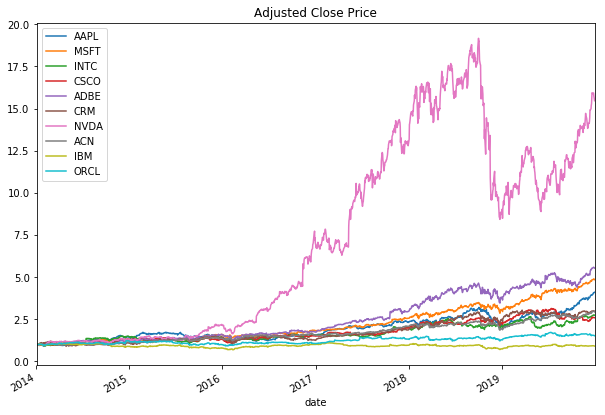

In [47]:
((stock_df.pct_change()+1).cumprod()).plot(figsize=(10,7))

plt.legend()

plt.title("Adjusted Close Price")
plt.show()

Note: NVDA (pink) has higher returns and volatility than the other 9 stocks tracked here.

# Benchmark

## Mean Average Percentage Error

\begin{equation*}
M = \frac{1}{n} \sum_{t=1}^n |{\frac{A_t - F_t}{A_t}}|
\end{equation*}

In [48]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [49]:
def train_test_actual_split(df, test_count=30):
    train_df = df[start_date:end_train_date]
    test_df = df
    actual_df = test_df.loc[test_df.index > end_train_date][1:test_count+1]
    return train_df, test_df, actual_df

In [50]:
train_df, test_df, actual_df = train_test_actual_split(stock_df, test_count=30)
print(train_df.shape)
print(test_df.shape)
print(actual_df.shape)

(1258, 10)
(1509, 10)
(30, 10)


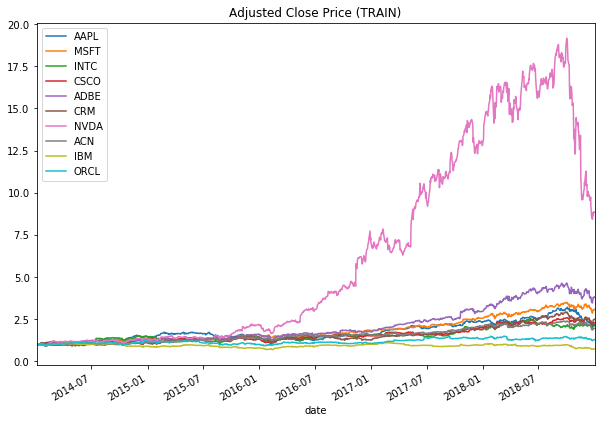

In [51]:
((train_df.pct_change()+1).cumprod()).plot(figsize=(10,7))

plt.legend()

plt.title("Adjusted Close Price (TRAIN)")
plt.show()

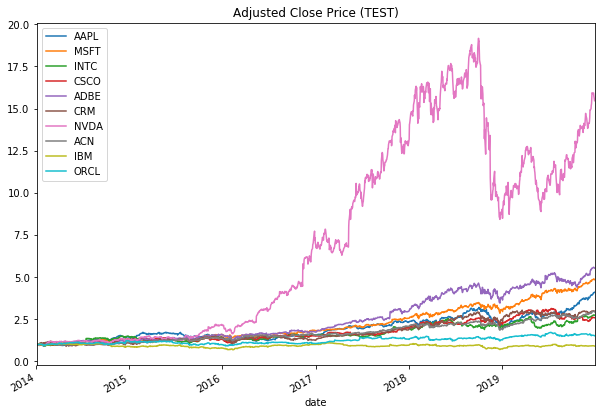

In [52]:
((test_df.pct_change()+1).cumprod()).plot(figsize=(10,7))


plt.legend()

plt.title("Adjusted Close Price (TEST)")
plt.show()

## Benchmark DataFrame

In [53]:
# Dictionary of stock_tickers and list of naive prediction values
data = dict(zip(stock_tickers, train_df.iloc[-1:].values[0]))

naive_df = pd.DataFrame(index=range(30), columns=stock_tickers)
naive_df = naive_df.fillna(value=data)
naive_df.head()

,AAPL,MSFT,INTC,CSCO,ADBE,CRM,NVDA,ACN,IBM,ORCL
0,155.037109,100.090057,45.563309,41.831917,226.240005,136.970001,132.980652,138.717056,107.346657,44.196228
1,155.037109,100.090057,45.563309,41.831917,226.240005,136.970001,132.980652,138.717056,107.346657,44.196228
2,155.037109,100.090057,45.563309,41.831917,226.240005,136.970001,132.980652,138.717056,107.346657,44.196228
3,155.037109,100.090057,45.563309,41.831917,226.240005,136.970001,132.980652,138.717056,107.346657,44.196228
4,155.037109,100.090057,45.563309,41.831917,226.240005,136.970001,132.980652,138.717056,107.346657,44.196228


## Benchmark MAPE

In [54]:
def create_MAPE_df(true_df, pred_df, time_frame=[1, 5, 10, 20, 30]):
    df = pd.DataFrame(index=stock_tickers)
    for t in time_frame:
        naive_mapes = []
        for i in range(len(stock_tickers)):
            naive_mapes.append(mape(true_df.iloc[0:t, i], pred_df.iloc[0:t, i]))
        df[f'{t}-day'] = naive_mapes
    return df

In [55]:
naive_mape_df = create_MAPE_df(actual_df, naive_df)
naive_mape_df

,1-day,5-day,10-day,20-day,30-day
AAPL,0.113969,5.742519,4.595358,3.284463,4.721019
MSFT,0.445016,1.351226,1.624779,2.866754,3.181494
INTC,0.318628,1.837778,2.525574,2.445840,3.296215
CSCO,0.884744,1.508310,1.279872,3.228992,5.220992
ADBE,0.743643,1.947438,3.344933,5.176915,7.199951
CRM,1.047583,3.299933,5.110505,6.518295,8.724319
NVDA,1.996765,3.941531,6.663630,8.216355,8.866475
ACN,0.298746,1.483902,2.511661,4.407236,6.140417
IBM,1.336689,2.810670,4.515386,8.203218,10.895536
ORCL,0.154786,2.973950,4.579319,6.633288,8.342352


# Prepare Data for DeepAR

## Save the Data Locally as JSON Lines

In [56]:
import os

data_dir = 'json_stock_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [57]:
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

In [58]:
def write_json_dataset(df, filename, start):
    with open(filename, 'wb') as f:
        for ticker in stock_tickers:
            json_obj = {'start': start,
                        'target': list(map(float, df[[ticker]].values))
                       }
            json_line = json.dumps(json_obj) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
        print(filename, 'saved')

In [59]:
start = train_df.index[0].__str__()

write_json_dataset(train_df, train_key, start)
write_json_dataset(test_df, test_key, start)

json_stock_data/train.json saved
json_stock_data/test.json saved


## Upload Data to S3

In [60]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [61]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = 'sagemaker-udacity-capstone-bucket'

In [62]:
print(bucket)

sagemaker-udacity-capstone-bucket


In [63]:
prefix = 'capstone-stock-prices'

train_prefix = f'{prefix}/train'
test_prefix = f'{prefix}/test'

train_path = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path = sagemaker_session.upload_data(test_key, bucket=bucket, key_prefix=test_prefix)

print('Training data is stored in:', train_path)
print('Testing data is stored in:', test_path)

Training data is stored in: s3://sagemaker-udacity-capstone-bucket/capstone-stock-prices/train/train.json
Testing data is stored in: s3://sagemaker-udacity-capstone-bucket/capstone-stock-prices/test/test.json


# Train DeepAR Estimator

In [64]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name,
                           'forecasting-deepar')

## Instantiate Estimator

In [65]:
from sagemaker.estimator import Estimator

# dir to save model artifacts
s3_output_path = f's3://{bucket}/{prefix}/output'

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

## Set Hyperparameters

In [66]:
hyperparameters = {'prediction_length': '30',
                   'context_length': '30',
                   'time_freq': 'D',
                   'epochs': '50',
                   'early_stopping_patience': '10',
                   'num_layers': 2,
                   'num_cells': '50',
                   'learning_rate': '1e-3'
                  }

In [67]:
estimator.set_hyperparameters(**hyperparameters)

## Training Job

In [68]:
%%time

data_channels = {
    'train': train_path,
    'test': test_path
}

estimator.fit(inputs=data_channels)

2020-02-19 17:26:43 Starting - Starting the training job...
2020-02-19 17:26:44 Starting - Launching requested ML instances......
2020-02-19 17:27:49 Starting - Preparing the instances for training......
2020-02-19 17:28:57 Downloading - Downloading input data...
2020-02-19 17:29:41 Training - Training image download completed. Training in progress..Arguments: train
[02/19/2020 17:29:45 INFO 140248077891392] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience':

# Deploy and Create a Predictor

In [69]:
%%time
predictor = estimator.deploy(initial_instance_count = 1,
                             instance_type = 'ml.t2.medium',
                             content_type = 'application/json'
                             )

-------------------------!CPU times: user 402 ms, sys: 8.58 ms, total: 411 ms
Wall time: 12min 32s


# Generate Predictions

In [91]:
def json_predictor_input(start, df, num_samples=30, quantiles=['0.1', '0.5', '0.9']):
    
    instances = []
    
    for ticker in stock_tickers:
        json_obj = {'start': start, 
                    'target': list(map(float, df[[ticker]].values))
                   }
        instances.append(json_obj)
        
    configuration = {'num_samples': num_samples,
                     'output_types': ['quantiles'],
                     'quantiles': quantiles
                    }
    
    request_data = {'instances': instances,
                    'configuration': configuration
                   }
    
    return json.dumps(request_data).encode('utf-8')

In [92]:
def decode_prediction(prediction, encoding='utf-8'):
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list

In [93]:
def display_quantiles(prediction_list, target_list):
    for k in range(len(prediction_list)):
        prediction_list[k] = prediction_list[k].iloc[::1]
        plt.figure(figsize=(12,6))
        target_list[stock_tickers[k]].plot(label='target')
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

# Get a Prediction

In [94]:
# Get the start date
start = actual_df.index[0].__str__()

# Get the Prediction from the model
json_prediction = predictor.predict(json_predictor_input(start, train_df))

# Decode the prediction
prediction_list = decode_prediction(json_prediction)

# Display Results

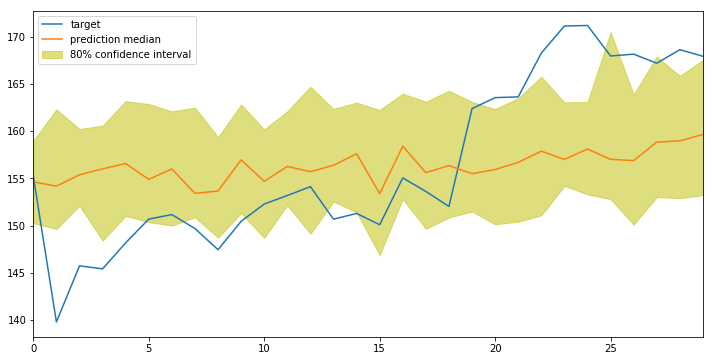

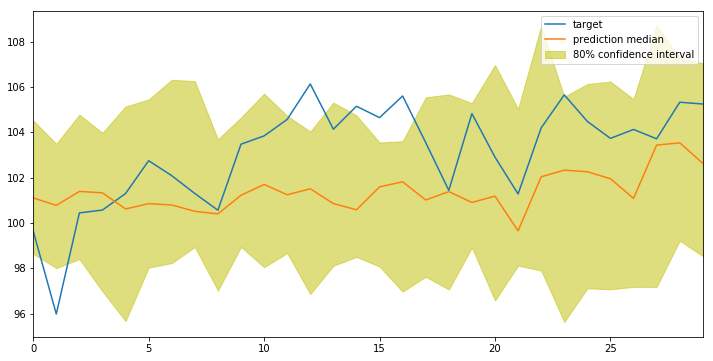

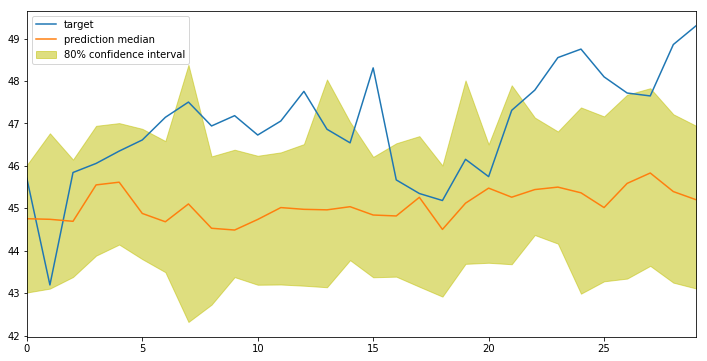

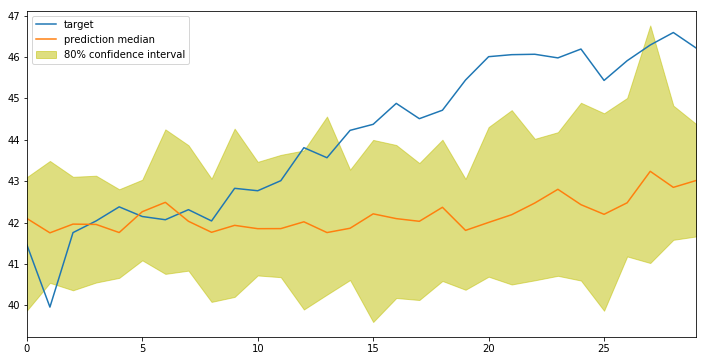

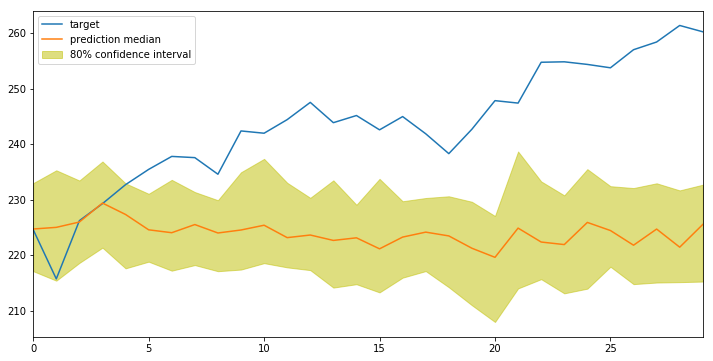

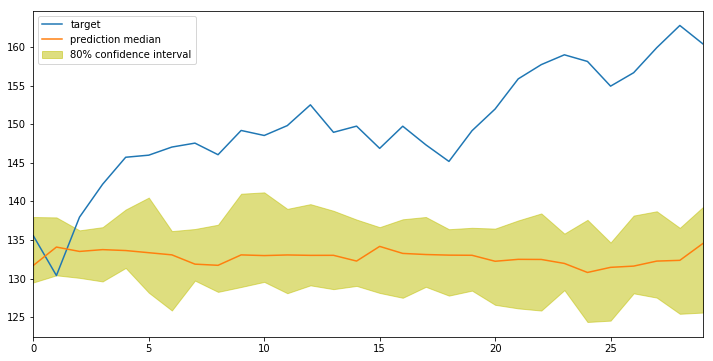

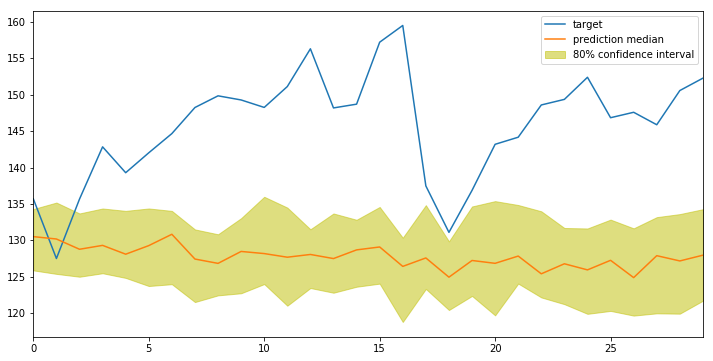

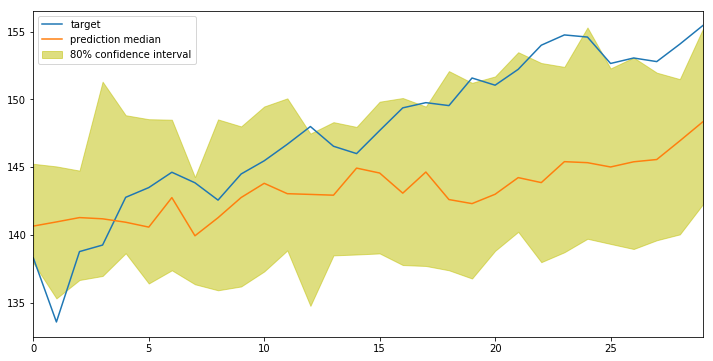

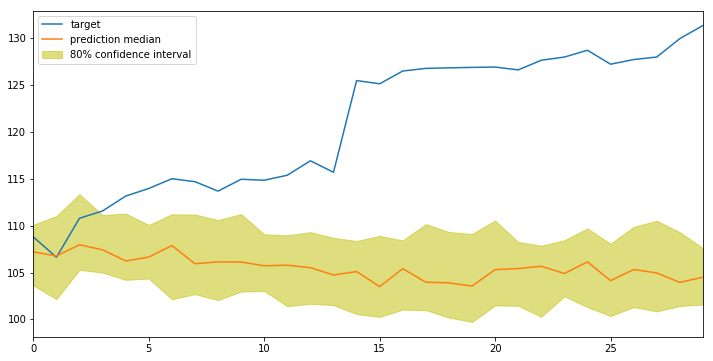

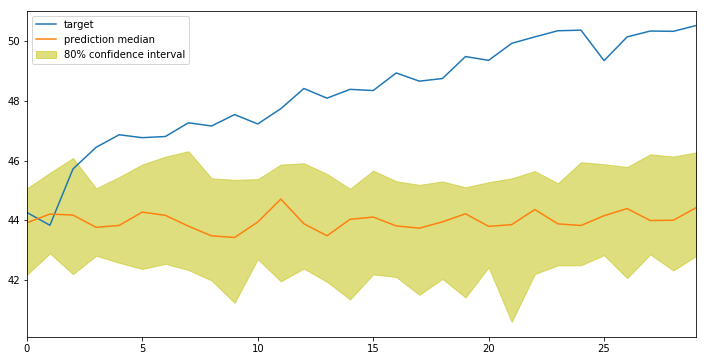

In [95]:
target_df = actual_df.reset_index()
display_quantiles(prediction_list, target_df)

# Prediction DataFrame

In [84]:
pred_data = []
for i in range(len(stock_tickers)):
    pred_data.append(prediction_list[i]['0.5'].values.tolist())

pred_data_columns = dict(zip(stock_tickers, pred_data))

pred_df = pd.DataFrame(pred_data_columns)
pred_df.head()

,AAPL,MSFT,INTC,CSCO,ADBE,CRM,NVDA,ACN,IBM,ORCL
0,155.608337,99.697807,45.167831,42.295456,225.575455,132.243561,131.100525,141.212769,106.493858,43.692024
1,155.230270,100.885239,45.606422,41.946865,226.787338,135.109619,129.553482,141.318893,106.881790,43.573456
2,155.876694,101.859558,45.111252,42.396553,224.488159,134.390671,129.851257,141.020447,107.122154,43.734531
3,156.066681,101.707878,45.762886,42.034447,226.802612,134.903732,129.035431,141.975220,106.593582,43.721188
4,155.011703,101.530624,45.292686,42.113503,224.573410,135.521332,130.148438,141.508163,107.354660,44.072666


# Analyse Results

In [85]:
model_mape_df = create_MAPE_df(actual_df, pred_df)
model_mape_df

,1-day,5-day,10-day,20-day,30-day
AAPL,0.254058,6.051608,4.718350,3.385858,4.377843
MSFT,0.051375,1.584736,1.405196,2.205084,2.265586
INTC,1.183835,2.258105,3.091897,3.207656,3.782521
CSCO,2.002647,1.830626,1.610269,3.760963,5.203604
ADBE,0.447721,2.179233,3.752196,6.084211,8.268650
CRM,2.439279,4.156265,6.468926,8.261602,10.364214
NVDA,3.382369,5.101446,8.549547,10.309865,11.585732
ACN,2.103260,2.470848,1.800718,2.795416,3.814132
IBM,2.120504,3.054339,5.371938,9.699062,12.721099
ORCL,1.293850,3.614634,5.418383,7.360489,8.788813


In [86]:
print(model_mape_df)
print(naive_mape_df)

         1-day     5-day    10-day     20-day     30-day
AAPL  0.254058  6.051608  4.718350   3.385858   4.377843
MSFT  0.051375  1.584736  1.405196   2.205084   2.265586
INTC  1.183835  2.258105  3.091897   3.207656   3.782521
CSCO  2.002647  1.830626  1.610269   3.760963   5.203604
ADBE  0.447721  2.179233  3.752196   6.084211   8.268650
CRM   2.439279  4.156265  6.468926   8.261602  10.364214
NVDA  3.382369  5.101446  8.549547  10.309865  11.585732
ACN   2.103260  2.470848  1.800718   2.795416   3.814132
IBM   2.120504  3.054339  5.371938   9.699062  12.721099
ORCL  1.293850  3.614634  5.418383   7.360489   8.788813
         1-day     5-day    10-day    20-day     30-day
AAPL  0.113969  5.742519  4.595358  3.284463   4.721019
MSFT  0.445016  1.351226  1.624779  2.866754   3.181494
INTC  0.318628  1.837778  2.525574  2.445840   3.296215
CSCO  0.884744  1.508310  1.279872  3.228992   5.220992
ADBE  0.743643  1.947438  3.344933  5.176915   7.199951
CRM   1.047583  3.299933  5.110505  6

In [87]:
time_frame=[1, 5, 10, 20, 30]

compare_df = pd.DataFrame(index=stock_tickers)
for ticker in stock_tickers:
    for t in time_frame:
        compare_df[f'{t}-day'] = np.subtract(model_mape_df[f'{t}-day'], naive_mape_df[f'{t}-day'])

In [88]:
compare_df

,1-day,5-day,10-day,20-day,30-day
AAPL,0.140089,0.309088,0.122992,0.101395,-0.343176
MSFT,-0.393641,0.233510,-0.219583,-0.661670,-0.915907
INTC,0.865208,0.420327,0.566323,0.761815,0.486305
CSCO,1.117903,0.322315,0.330397,0.531971,-0.017388
ADBE,-0.295921,0.231795,0.407263,0.907297,1.068699
CRM,1.391696,0.856332,1.358421,1.743307,1.639895
NVDA,1.385604,1.159915,1.885917,2.093511,2.719256
ACN,1.804514,0.986946,-0.710943,-1.611820,-2.326285
IBM,0.783815,0.243668,0.856552,1.495844,1.825563
ORCL,1.139064,0.640684,0.839064,0.727201,0.446462


In [89]:
sum_df = compare_df.sum()
mean_df = compare_df.mean()

In [90]:
print("Sum of MAPE")
print('-'*20)
print(sum_df)
print("\nSum:", sum_df.sum())
print('-'*20)
print("Mean of MAPE")
print('-'*20)
print(mean_df)
print("\nMean", mean_df.mean())

Sum of MAPE
--------------------
1-day     7.938330
5-day     5.404581
10-day    5.436402
20-day    6.088851
30-day    4.583425
dtype: float64

Sum: 29.45158879892011
--------------------
Mean of MAPE
--------------------
1-day     0.793833
5-day     0.540458
10-day    0.543640
20-day    0.608885
30-day    0.458342
dtype: float64

Mean 0.5890317759784021


# Delete Endpoint

In [ ]:
predictor.delete_endpoint()

<h1 style="text-align:center; border-top: 4px solid black; border-bottom: 4px solid black; padding: 8px;">Model For Web App</h1>

# Get Current Data

In [ ]:
from datetime import timedelta

# Set Dates
start_date = '01/01/2014'
end_date = datetime.now()
end_train_date = end_date - timedelta(days=365)

start_timestamp = int(time.mktime(datetime.strptime(start_date, '%m/%d/%Y').timetuple()))
end_date_timestamp = int(datetime.timestamp(end_date))

In [ ]:
# Load Historical Data
data = []
for ticker in stock_tickers:
    data.append(load_historical_data('1d', start_timestamp, end_date_timestamp, ticker))

stock_df = data[0].copy()

# Create DataFrame
for i in range(1, len(data)):
    stock_df = stock_df.merge(right=data[i], left_index=True, right_index=True)

stock_df = stock_df.dropna()
stock_df.head()

In [ ]:
train_df = stock_df[start_date:end_train_date]
test_df = stock_df
actual_df = test_df.loc[test_df.index > end_train_date]
actual_df.shape

# Save the Data Locally

In [ ]:
start = train_df.index[0].__str__()

write_json_dataset(train_df, train_key, start)
write_json_dataset(test_df, test_key, start)

# Upload Data to S3

In [ ]:
train_path = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path = sagemaker_session.upload_data(test_key, bucket=bucket, key_prefix=test_prefix)

print('Training data is stored in:', train_path)
print('Testing data is stored in:', test_path)

# Create Estimator

In [ ]:
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

hyperparameters = {'prediction_length': '30',
                   'context_length': '30',
                   'time_freq': 'D',
                   'epochs': '50',
                   'early_stopping_patience': '10',
                   'num_layers': 2,
                   'num_cells': '50',
                   'learning_rate': '1e-3'
                  }

estimator.set_hyperparameters(**hyperparameters)

# Create Training Job

In [ ]:
%%time

data_channels = {
    'train': train_path,
    'test': test_path
}

estimator.fit(inputs=data_channels)

# Create and Deploy Predictor

In [ ]:
%%time
predictor = estimator.deploy(initial_instance_count = 1,
                             instance_type = 'ml.t2.medium',
                             content_type = 'application/json'
                             )

# Test Model Accuracy

In [ ]:
# Get the start date
start = train_df.index[0].__str__()
print(start)
# Get the Prediction from the model
json_prediction = predictor.predict(json_predictor_input(start, train_df))

# Decode the prediction
prediction_list = decode_prediction(json_prediction)

In [ ]:
target_df = actual_df.reset_index()
display_quantiles(prediction_list, target_df[:30])